In [1]:
from astropy.table import Table, join, vstack
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
import astropy.units as u
from dustmaps.edenhofer2023 import Edenhofer2023Query
import extinction

import sys
sys.path.append('../')

import wdphoto
import pyphot

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
model_sed, key_dict = wdphoto.utils.read_cache('../caches/warwick_cache_table.csv')

In [3]:
catalog = Table.read('raddi.csv')

In [4]:
stardats = []
# Astroquery row limits mean that if the length of the table is more than 2000, split the query into multiple calls.
iters = (len(catalog)+2000) // 2000

for i in range(iters):
    ADQL_CODE = """SELECT dist.source_id, dist.r_med_geo
                    FROM gaiadr3.gaia_source as gaia
                    JOIN external.gaiaedr3_distance as dist
                    ON gaia.source_id = dist.source_id      
                    WHERE gaia.source_id in {}""".format(tuple(catalog['SOURCE_ID'][2000*i:2000*i+2000]))
    stardats.append(Gaia.launch_job(ADQL_CODE,dump_to_file=False).get_results())
gaia_data = vstack(stardats)
catalog = join(catalog, gaia_data, keys_left='SOURCE_ID', keys_right='source_id')
    

In [5]:
# create a new column in catalog containing the skycoord object for each star using the bailer-jones distances
coords = [SkyCoord(frame="icrs", ra=catalog['ra'][i]*u.deg, dec=catalog['dec'][i]*u.deg, distance = catalog['r_med_geo'][i] * u.pc) for i in range(len(catalog))]
catalog['wd_coords'] = coords

# query Edenhofer2023 to get E(B-V) in arbitrary units
bsq = Edenhofer2023Query() # instantiate the Edenhofer query
bsq_res = bsq.query(catalog['wd_coords']).copy()
bsq_res[np.isnan(bsq_res)] = 0 # don't correct any rows with failed queries

Optimizing map for querying (this might take a couple of seconds)...


In [6]:
# convert to actual units (todo: check the dustmaps docs)
Ebv = bsq_res*0.901*0.98 # i don't totally remember the details of why this is necessary
catalog['E(B-V)'] = Ebv
catalog['e_E(B-V)'] = Ebv*0.2

# Parameters for correcting using Gaia
Rv = 3.1
catalog['A_v0'] = catalog['E(B-V)']*Rv

# fetch Gaia photometric band pivot wavelengths and store in `gaia_phot_wavl`
lib = pyphot.get_library()
gaia_filters = [lib['Gaia_G'], lib['Gaia_BP'], lib['Gaia_RP']]
gaia_phot_wavl = np.array([filter.lpivot.to('angstrom').value for filter in gaia_filters])

# for each point, find extinction using the parameters we defined above
ext_all = []
for av0 in catalog['A_v0']:
    ext_all.append( extinction.fitzpatrick99(gaia_phot_wavl, av0, Rv) )
ext_all = np.array(ext_all)
    
# save the extinction in each band
catalog['G_ext'] = ext_all.T[0]
catalog['BP_ext'] = ext_all.T[1]
catalog['RP_ext'] = ext_all.T[2]

# subtract out the extinction to find de-reddened magnitude
catalog['GAIA_G'] = catalog['phot_g_mean_mag'] - catalog['G_ext']
catalog['GAIA_BP'] = catalog['phot_bp_mean_mag'] - catalog['BP_ext']
catalog['GAIA_RP'] = catalog['phot_rp_mean_mag'] - catalog['RP_ext']

# delete bayestar query because it uses a lot of memory
del bsq

In [7]:
lib = pyphot.get_library()

n = 60

obs_mag = np.array(catalog[['GAIA_G', 'GAIA_BP', 'GAIA_RP']])
e_obs_mag = np.array(catalog[['e_gmag', 'e_bpmag', 'e_rpmag']])
filters = [lib['Gaia_G'], lib['Gaia_BP'], lib['Gaia_RP']]
distance = np.array(catalog['r_med_geo'])

In [8]:
catalog['radius_wdphoto'] = np.ones(len(catalog))*np.nan
catalog['e_radius_wdphoto'] = np.ones(len(catalog))*np.nan
catalog['teff_wdphoto'] = np.ones(len(catalog))*np.nan
catalog['e_teff_wdphoto'] = np.ones(len(catalog))*np.nan

for i in tqdm(range(len(catalog[:n]))):
    radius, e_radius, teff, e_teff = wdphoto.fit.get_parameters(obs_mag[i], e_obs_mag[i], filters, distance[i])

    catalog['radius_wdphoto'][i] = radius
    catalog['e_radius_wdphoto'][i] = e_radius
    catalog['teff_wdphoto'][i] = teff
    catalog['e_teff_wdphoto'][i] = e_teff

100%|██████████| 60/60 [01:13<00:00,  1.23s/it]


In [9]:
catalog['radius_wdphoto_cache'] = np.ones(len(catalog))*np.nan
catalog['e_radius_wdphoto_cache'] = np.ones(len(catalog))*np.nan
catalog['teff_wdphoto_cache'] = np.ones(len(catalog))*np.nan
catalog['e_teff_wdphoto_cache'] = np.ones(len(catalog))*np.nan

for i in tqdm(range(len(catalog[:n]))):
    radius, e_radius, teff, e_teff = wdphoto.fit.get_parameters(obs_mag[i], e_obs_mag[i], filters, distance[i], cache_obj = (model_sed, key_dict))

    catalog['radius_wdphoto_cache'][i] = radius
    catalog['e_radius_wdphoto_cache'][i] = e_radius
    catalog['teff_wdphoto_cache'][i] = teff
    catalog['e_teff_wdphoto_cache'][i] = e_teff

100%|██████████| 60/60 [00:05<00:00, 10.74it/s]


Text(0, 0.5, 'Cache Radius')

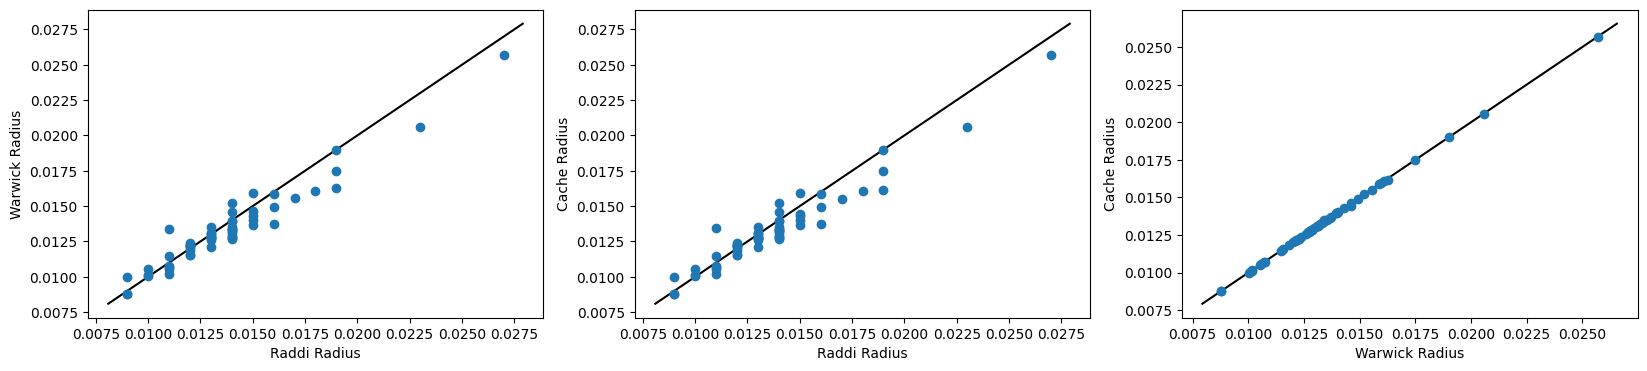

In [10]:
plt.figure(figsize=(20,4))

plt.subplot(131)
plt.scatter(catalog[:n]['Radius'], catalog[:n]['radius_wdphoto'])
xlims = plt.xlim()
plt.plot(xlims, xlims, c='k', zorder=0)
plt.xlabel('Raddi Radius')
plt.ylabel('Warwick Radius')

plt.subplot(132)
plt.scatter(catalog[:n]['Radius'], catalog[:n]['radius_wdphoto_cache'])
xlims = plt.xlim()
plt.plot(xlims, xlims, c='k', zorder=0)
plt.xlabel('Raddi Radius')
plt.ylabel('Cache Radius')

plt.subplot(133)
plt.scatter(catalog[:n]['radius_wdphoto'], catalog[:n]['radius_wdphoto_cache'])
xlims = plt.xlim()
plt.plot(xlims, xlims, c='k', zorder=0)
plt.xlabel('Warwick Radius')
plt.ylabel('Cache Radius')